In [3]:
#import packages
import pandas as pd
import numpy as np
#import category_encoders as ce
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
#from xgboost import XGBClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_validate, cross_val_predict
from sklearn.metrics import make_scorer
from sklearn.metrics import recall_score, precision_score, f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from numpy import mean
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import operator
import itertools
import operator
from itertools import islice
import glob
import os
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_validate
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
#from xgboost import XGBClassifier
from sklearn import metrics
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB 
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import RidgeClassifier
#import pandasql as ps
import matplotlib.pyplot as plt
from fastdtw import fastdtw
from matplotlib.pyplot import figure
from dtaidistance import dtw
from dtaidistance import dtw_visualisation as dtwvis
from scipy.spatial.distance import euclidean

In [4]:
#data read
data = pd.read_excel('data_KPI.xlsx')
del data['Unnamed: 0']

In [14]:
#Inflation calculation
rates=[]
years = [*range(2012,2020)]

    
for j in range(8):                          
    rates.append(np.percentile(data['Value'].loc[data['Year'] == 2019],50)/np.percentile(data['Value'].loc[data['Year'] == years[j]],50))
    
for k in range(8):
    data.loc[data['Year'] == years[k], 'modded'] = round(data['Value']*rates[k]).astype(int)

#Descriptive stats
ev = []
percentile = []
maxim = []
median = []
mean = []
year = list(range(2012,2020))

for i in range(8):
    ev.append(data.loc[data['Year'] == year[i]])

for j in range(8):
    percentile.append(np.percentile(ev[j]['modded'],75))
    maxim.append(np.percentile(ev[j]['modded'],100))
    median.append(np.median(ev[j]['modded']))
    mean.append(np.mean(ev[j]['modded']))
leiro = pd.DataFrame(list(zip(year, median, percentile, maxim, mean)), 
               columns =['year','median','Q3','max', 'mean'])

leiro['median'] = leiro['median']/1000
leiro['mrate'] = leiro['median'][7]/leiro['median']
leiro['Q3'] = leiro['Q3']/1000
leiro['qrate'] = leiro['Q3'][7]/leiro['Q3']
leiro['max'] = leiro['max']/1000
leiro['maxrate'] = leiro['max'][7]/leiro['max']
leiro['mean']= leiro['mean']/1000

leiro['median'] = leiro['median'].astype(int)
leiro['Q3'] = leiro['Q3'].astype(int)
leiro['max'] = leiro['max'].astype(int)
leiro['mean'] = leiro['mean'].astype(int)

leiro

,year,median,Q3,max,mean,mrate,qrate,maxrate
0,2012,600,1800,120000,1964,1.0,0.833333,1.666667
1,2013,600,1800,144000,2075,1.0,0.833333,1.388889
2,2014,600,1800,144000,2129,1.0,0.833333,1.388889
3,2015,600,1800,144000,2161,1.0,0.833333,1.388889
4,2016,600,1800,144000,2184,1.0,0.833333,1.388889
5,2017,600,1500,144000,2301,1.0,1.000000,1.388889
6,2018,600,1800,216000,2902,1.0,0.833333,0.925926
7,2019,600,1500,200000,2949,1.0,1.000000,1.000000


In [6]:
#individual time series creation
series = []
grouped_df = data.groupby("ID")
for i in grouped_df:
    series.append(i[1])

#store players with 4+ years of data
reduced = []
for i in range(len(series)):
    if len(series[i])>=4:
        reduced.append(series[i])

#selected and others ID collection
joid = []
roid = []
for i in range(len(reduced)):
    if reduced[i].Inlf_Value.mean()>=7:
        joid.append(reduced[i].ID[:1].values)
    else:
        roid.append(reduced[i].ID[:1].values)

#selected and others individual time series      
jolist = [] #selected
rolist = [] #others
for i in joid:
    jolist.append(data.loc[data.ID==i[0]])
    
for i in roid:
    rolist.append(data.loc[data.ID==i[0]])
    
#creating datasets from the groups
selected = data[data.ID.isin(joid)].copy()
others = data[data.ID.isin(roid)].copy()

In [5]:
features = ['Inlf_Value']

In [6]:
print(len(jolist))
print(len(rolist))

447
9771


### DTW (to skip this long process, please load the distances)

In [7]:
#selected distances
jodist = pd.DataFrame()
for i in range(len(jolist)):
    jolist[i]=jolist[i].reset_index(drop=True)
    
for j in features:
    joranges=[]
    for x in range(0,len(jolist)):
        #print('A vizsgált: ', x)
        for i in range(x, len(jolist)):
            if i!=x:
                d1 = jolist[x][j]
                d2 = jolist[i][j]
                distance = fastdtw(d1, d2)[0]
                joranges.append(distance)
                #print('The distance between the two time-series(',j,')  is %s' % distance)
    jodist[j] = joranges

In [8]:
#others distances
rodist = pd.DataFrame()
for i in range(len(rolist)):
    rolist[i]=rolist[i].reset_index(drop=True)
    
for j in features:
    roranges=[]
    for x in range(0,len(rolist),9):
        #print('A vizsgált: ', x)
        for i in range(x, len(rolist),9):
            if i!=x:
                d1 = rolist[x][j]
                d2 = rolist[i][j]
                distance = fastdtw(d1, d2)[0]
                roranges.append(distance)
                #print('The distance between the two time-series(',j,')  is %s' % distance)
    rodist[j] = roranges

In [9]:
#between groups distances
comd = pd.DataFrame()
for i in range(len(rolist)):
    rolist[i]=rolist[i].reset_index(drop=True)
for i in range(len(jolist)):
    jolist[i]=jolist[i].reset_index(drop=True)
    
for j in features:
    ranges=[]
    for x in range(0,len(jolist)):
        #print('A vizsgált: ', x)
        for i in range(0,len(rolist),9):
                d1 = jolist[x][j]
                d2 = rolist[i][j]
                distance = fastdtw(d1, d2)[0]
                ranges.append(distance)
                #print('The distance between the two time-series(',j,')  is %s' % distance)
    comd[j] = ranges

In [13]:
jodist.to_csv('jodist_Inlf_Value.csv')
rodist.to_csv('rodist_Inlf_Value.csv')
comd.to_csv('comd_Inlf_Value.csv')

### Load the DTW distances here

In [ ]:
jodist=pd.read_csv('jodist_Inlf_Value.csv')
del jodist['Unnamed: 0']
rodist=pd.read_csv('rodist_Inlf_Value.csv')
del rodist['Unnamed: 0']
comd=pd.read_csv('comd_Inlf_Value.csv')
del comd['Unnamed: 0']

In [11]:
print(len(jodist))
print(len(rodist))
print(len(comd))

99681
589155
485442


In [7]:
print('Best mean distance:', round(jodist.mean().values[0],3))
print('Others mean distance:', round(rodist.mean().values[0],3))
print('Between groups mean distance:', round(comd.mean().values[0],3))

Best mean distance: 2.429
Others mean distance: 3.597
Between groups mean distance: 9.353


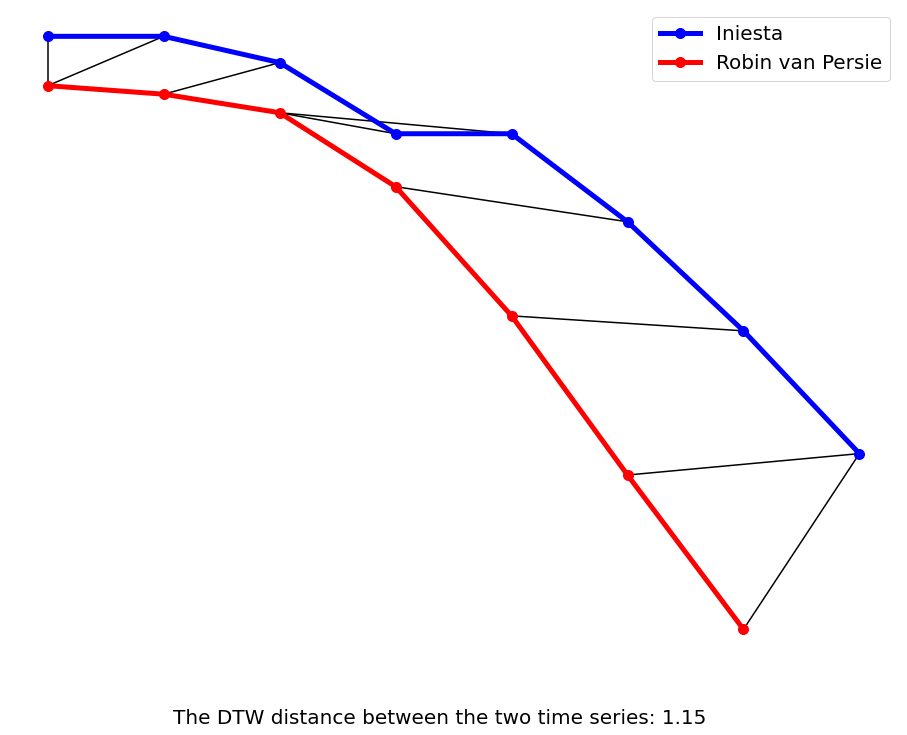

In [136]:
jolist[0]=jolist[0].reset_index(drop=True)
jolist[1]=jolist[1].reset_index(drop=True)
d1 = jolist[0]['Inlf_Value'].values
d2 = jolist[1]['Inlf_Value'].values
distance, warp_path = fastdtw(d1, d2)
fig, ax = plt.subplots(figsize=(16, 12))
# Remove the border and axes ticks
fig.patch.set_visible(False)
ax.axis('off')

for [map_x, map_y] in warp_path:
    ax.plot([map_x, map_y], [d1[map_x], d2[map_y]], '-k')

ax.plot(d1, color='blue', marker='o', markersize=10, linewidth=5, label ='Iniesta')
ax.plot(d2, color='red', marker='o', markersize=10, linewidth=5, label='Robin van Persie')
ax.tick_params(axis="both", which="major", labelsize=20)
txt='The DTW distance between the two time series: 1.15'
fig.text(.5, .05, txt, ha='center',fontsize=20)
#plt.title('Distance within the selected players',fontsize=20)
ax.legend(prop={'size': 20})

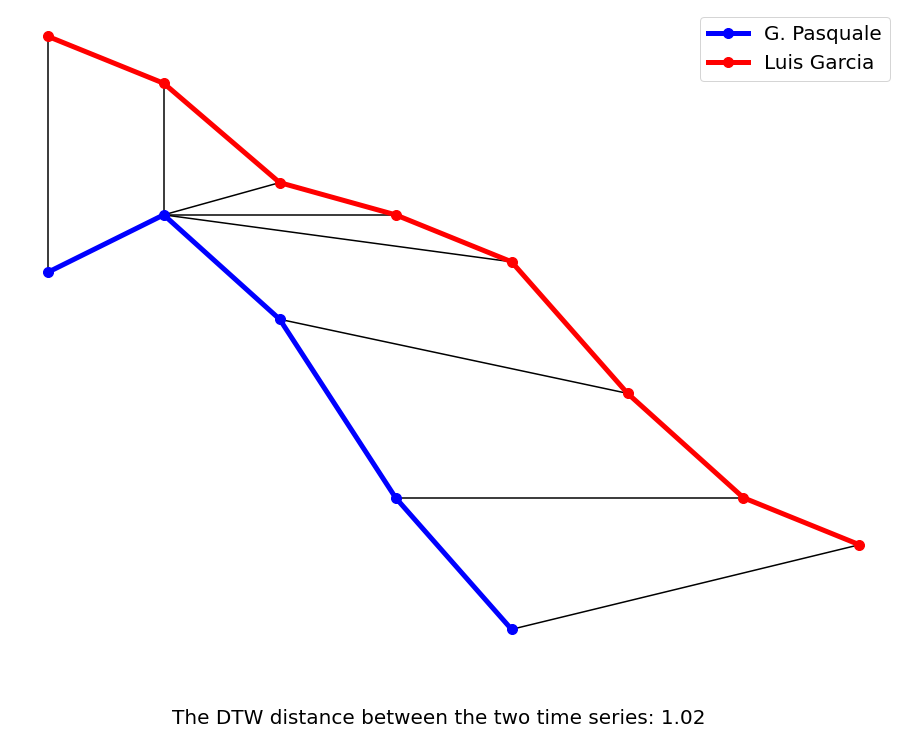

In [137]:
rolist[0]=rolist[0].reset_index(drop=True)
rolist[9]=rolist[9].reset_index(drop=True)
d1 = rolist[0]['Inlf_Value'].values
d2 = rolist[9]['Inlf_Value'].values
distance, warp_path = fastdtw(d1, d2)
fig, ax = plt.subplots(figsize=(16, 12))
# Remove the border and axes ticks
fig.patch.set_visible(False)
ax.axis('off')

for [map_x, map_y] in warp_path:
    ax.plot([map_x, map_y], [d1[map_x], d2[map_y]], '-k')

ax.plot(d1, color='blue', marker='o', markersize=10, linewidth=5, label ='G. Pasquale')
ax.plot(d2, color='red', marker='o', markersize=10, linewidth=5, label='Luis Garcia')
ax.tick_params(axis="both", which="major", labelsize=20)
txt='The DTW distance between the two time series: 1.02'
fig.text(.5, .05, txt, ha='center',fontsize=20)
#plt.title('Distance within the other players',fontsize=20)
ax.legend(prop={'size': 20})

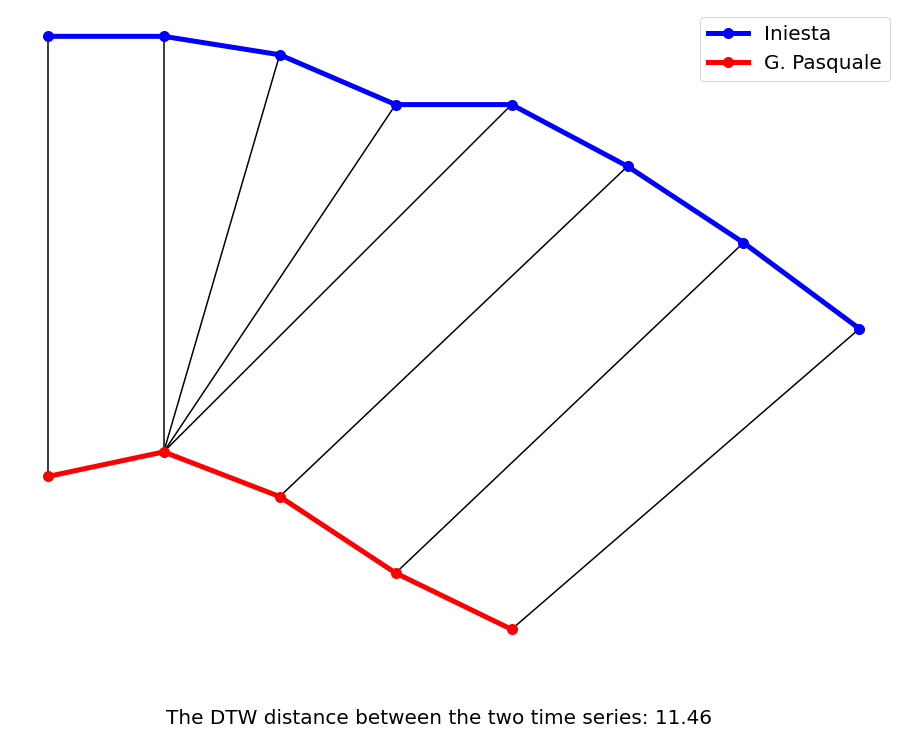

In [139]:
d1 = jolist[0]['Inlf_Value'].values
d2 = rolist[0]['Inlf_Value'].values
distance, warp_path = fastdtw(d1, d2)
fig, ax = plt.subplots(figsize=(16, 12))
# Remove the border and axes ticks
fig.patch.set_visible(False)
ax.axis('off')

for [map_x, map_y] in warp_path:
    ax.plot([map_x, map_y], [d1[map_x], d2[map_y]], '-k')

ax.plot(d1, color='blue', marker='o', markersize=10, linewidth=5, label = 'Iniesta')
ax.plot(d2, color='red', marker='o', markersize=10, linewidth=5, label = 'G. Pasquale')
ax.tick_params(axis="both", which="major", labelsize=20)
txt='The DTW distance between the two time series: 11.46'
fig.text(.5, .05, txt, ha='center',fontsize=20)
#plt.title('Distance between the two groups',fontsize=20)
ax.legend(prop={'size': 20})